# Ai go with GPU

Le but est d'entrainer un modèle à évaluer des plateaux de go. Nous avions à notre disposition 41563 plateaux avec leur score. La lecture de ce jupyter Notebook trace l'évolution chronologique de notre travail. Nous avons dupliqué les données d'exemple, puis nous avons défini notre modèle à tâtons. Nous sommes fiers de vous présenter un modèle une MAE de 0,0822.

L'entraînement a été réalisé sur Google Colab, avec l'option GPU pour :
- Ne pas faire souffrir nos petites machines
- gagner beaucoup de temps dans la phase de tests de paramètres a.k.a. *la cuisine*
- pouvoir monter le nombre d'epochs une fois le modèle assez bien défini
- travailler ensemble à distance

# Récupération des données d'entraînement

On télécharge les données d'entraînement au format json. Il sera utilisé pour créer un tableau Numpy sur lequel nous ferons notre entraînement.

In [ ]:
# Import du fichier d'exemples

def get_raw_data_go():
    """ Returns the set of samples from the local file or download it if it does not exists """
    import gzip, os.path
    import json

    raw_samples_file = "samples-9x9.json.gz"

    if not os.path.isfile(raw_samples_file):
        print("File", raw_samples_file, "not found, I am downloading it...", end="")
        import urllib.request 
        urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/samples-9x9.json.gz", "samples-9x9.json.gz")
        print(" Done")

    with gzip.open("samples-9x9.json.gz") as fz:
        data = json.loads(fz.read().decode("utf-8"))
    return data

data = get_raw_data_go()
print("We have", len(data),"examples")

File samples-9x9.json.gz not found, I am downloading it... Done
We have 41563 examples


# Conversion json --> Numpy

Ci-dessous nous définissons les fonctions permettant de passer d'un fichier json à un tableau numpy.

Les éléments de ce tableau auront pour shape `(2, 9 ,9)`. Un plateau est donc représenté par 2 tableaux 9x9. Le premier indique où se trouvent les pions **noirs**, le deuxième indique où sont les **blancs**.



In [ ]:
## FUNCTIONS JSON --> NUMPY ARRAY
import numpy as np

def name_to_coord(s):
    """
    Takes a string coordinate for Go boards and converts it in numeral coordinates
    Exemple : "B5" gives 6, 1
    """
    assert s != "PASS"
    indexLetters = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'J':8}
    
    col = indexLetters[s[0]]
    lin = int(s[1:]) - 1
    return col, lin


def json_move_to_matrix(move):
    """
    For a move in the json file, creates the numpy matrix to work with
    Dimensions:
    0 : black_stones
    1 : white_stones
    """
    m = np.zeros((2, 9, 9))
    for c, color in enumerate(['black_stones', 'white_stones']):
        for pawn in move[color]:
        row, col = name_to_coord(pawn)
        m[c][row][col] = 1
    return m

def json_to_matrix(data):
    """ Call json_move_to_matrix() on each element of the json data """
    m = []
    for i in range(len(data)):
        mi = json_move_to_matrix(data[i])
        m.append(mi)
    return np.array(m)

# Multiplication des données pour l'entraînement

Le fichier fourni met à notre disposition 41563 sur lesquels s'entraîner. C'est bien mais on peut faire beaucoup mieux.

Puisque dans le jeu de go, la valeur d'un plateau est insenible à toute rotation ou toute symétrie, on peut générer d'autres plateaux à partir des exemples d'origine. Nous réalisons :

- les symétries Haut-Bas
- les symétries Gauche-Droite
- les rotations de 90°
- les rotations de 180°
- les rotations de 270°
- la combinaison symétrie Haut-Bas + rotation de 90°
- la combinaison symétrie Haut-Bas + rotation de 180°
- la combinaison symétrie Haut-Bas + rotation de 270°
- la combinaison symétrie Gauche-Droite + rotation de 90°
- la combinaison symétrie Gauche-Droite + rotation de 180°
- la combinaison symétrie Gauche-Droite + rotation de 270°

On a donc une **multiplication de nos données d'origine par 12** ce qui nous donne 498756 données.


In [ ]:
## FUNCTIONS TO ENLARGE DATA

def make_up_down_symetry(elem):
    """ Makes a up-down symmetry of the (2, 9, 9) matrix given """
    new_symmetry = []
    for depth in elem:
        new_symmetry.append(np.flipud(depth))
    return np.array(new_symmetry)
      
def make_left_right_symetry(elem):
    """ Makes a left-right symmetry of the (2, 9, 9) matrix given """
    new_symmetry = []
    for depth in elem:
        new_symmetry.append(np.fliplr(depth))
    return np.array(new_symmetry)

def make_90_rotation(elem):
    """ Makes a 90° rotation of the (2, 9, 9) matrix given """
    new_rotation = []
    for depth in elem:
        new_rotation.append(np.rot90(depth))
    return np.array(new_rotation)

def make_180_rotation(elem):
    """ Makes a 180° rotation of the (2, 9, 9) matrix given """
    new_rotation = []
    for depth in elem:
        new_rotation.append(np.rot90(np.rot90(depth)))
    return np.array(new_rotation)

def make_270_rotation(elem):
    """ Makes a 270° rotation of the (2, 9, 9) matrix given """
    new_rotation = []
    for depth in elem:
        new_rotation.append(np.rot90(np.rot90(np.rot90(depth))))
    return np.array(new_rotation)

def append_new_board(board, transformation_type, original_index, verbose, enlarged, y, y_data):
    """ Appends a transformation of the original data to the data"""
    if verbose: print(f"{transformation_type}:\n", board)
    enlarged.append(board)
    y.append(y_data[original_index])

def enlarge_data(data_numpy, settings, verbose=False):
    """
    Creates more boards using symmetries and rotations.
    Combinations will also be added.
    Example : if UP_DOWN and deg90 are set to True, you will add
    sym_up_down(board), rot90(board) AND rot90(sym_up_down(board))
    settings is a dictionary that give us which transformations we have to perform on the original data.
    """
    # y_data is the value we want to predict for each board
    y_data = np.array([d["black_wins"] / d["rollouts"] for d in mydata])
    enlarged = []
    y = []
    for e, elem in enumerate(data_numpy): # for each original element
        if verbose: print(f"Orginal:{elem.dtype}\n", elem)
        enlarged.append(elem)
        y.append(y_data[e])

        # symmetries
        if settings["UP_DOWN"]:
        s1 = make_up_down_symetry(elem)
        append_new_board(s1, "Symmetry 1", e, verbose, enlarged, y, y_data)
        if settings["LEFT_RIGHT"]:
        s2 = make_left_right_symetry(elem)
        append_new_board(s2, "Symmetry 2", e, verbose, enlarged, y, y_data)

        # rotations
        if settings["deg90"]:
        r1 = make_90_rotation(elem)
        append_new_board(r1, "Rotation 1", e, verbose, enlarged, y, y_data)

        if settings["deg180"]:
        r2 = make_180_rotation(elem)
        append_new_board(r2, "Rotation 2", e, verbose, enlarged, y, y_data)

        if settings["deg270"]:
        r3 = make_270_rotation(elem)
        append_new_board(r3, "Rotation 3", e, verbose, enlarged, y, y_data)

        # combinaison
        if settings["UP_DOWN"]:
        if settings["deg90"]:
            c1 = make_90_rotation(s1)
            append_new_board(c1, "Combinaison 1", e, verbose, enlarged, y, y_data)
        if settings["deg180"]:
            c2 = make_180_rotation(s1)
            append_new_board(c2, "Combinaison 2", e, verbose, enlarged, y, y_data)
        if settings["deg270"]:
            c3 = make_270_rotation(s1)
            append_new_board(c3, "Combinaison 3", e, verbose, enlarged, y, y_data)
        if settings["LEFT_RIGHT"]:
        if settings["deg90"]:
            c4 = make_90_rotation(s2)
            append_new_board(c4, "Combinaison 4", e, verbose, enlarged, y, y_data)
        if settings["deg180"]:
            c5 = make_180_rotation(s2)
            append_new_board(c5, "Combinaison 5", e, verbose, enlarged, y, y_data)
        if settings["deg270"]:
            c6 = make_270_rotation(s2)
            append_new_board(c6, "Combinaison 6", e, verbose, enlarged, y, y_data)
    return np.array(enlarged), np.array(y)

In [ ]:
mydata = data # Use mydata = data[:3] for tests

# Dictionary to select which boards you want to add
enrich_settings = {
    "UP_DOWN": True,     # Symmetry up-down
    "LEFT_RIGHT": True,  # Symmetry left-right
    "deg90": True,       # Rotation 90°
    "deg180": True,      # Rotation 180°
    "deg270": True       # Rotation 270°
}

# Converts json data to numpy array
print("Converting data to numpy array...", end="")
np_data = json_to_matrix(mydata)
print("\033[92m Done\033[0m")

# enlarges the data with rotations and symmetries
print("Enlarging data (can be long)...", end="")
np_data, y_data = enlarge_data(np_data, enrich_settings, verbose=False)
print("\033[92m Done\033[0m")

print("np_data.shape:", np_data.shape)
print("y_data.shape", y_data.shape)

Converting data to numpy array... Done
Enlarging data (can be long)... Done
np_data.shape: (498756, 2, 9, 9)
y_data.shape (498756,)


# Séparation des données d'entraînement, de test et de validation

On utilise la fonction `train_test_split` de *sklearn* pour séparer nos données. On lui dit de garder 80% des données pour l'entraînement, 10% pour les tests et 10% pour la validation. Cette fonction a l'avantage de **mélanger** nos données.

Les données d'entraînement et de test seront utilisées pour *fit* le modèle. Les données de valisation seront utilisées pour tester nos prédictions.

In [ ]:
from sklearn.model_selection import train_test_split

test_percentage = 0.10
validation_percentage = 0.10

go_train, go_test, y_train, y_test = train_test_split(np_data, y_data, test_size=test_percentage)
go_train, go_validation, y_train, y_validation = train_test_split(go_train, y_train, test_size= validation_percentage/(1 - test_percentage))


print("go_train -> shape:", go_train.shape, ", dtype:", go_train.dtype)
print("y_train -> shape:", y_train.shape, ", dtype:", y_train.dtype)
print("go_test -> shape:", go_test.shape, ", dtype:", go_test.dtype)
print("y_test -> shape:", y_test.shape, ", dtype:", y_test.dtype)
print("go_validation -> shape:", go_validation.shape, ", dtype:", go_validation.dtype)
print("y_validation -> shape:", y_validation.shape, ", dtype:", y_validation.dtype)

valsum = len(y_train) + len(y_test) + len(y_validation)
print(f"\nTrain data is {len(y_train)/valsum:.2f}%, test data is {len(y_test)/valsum:.2f}% and validation data is {len(y_validation)/valsum:.2f}%")

go_train -> shape: (399004, 2, 9, 9) , dtype: float64
y_train -> shape: (399004,) , dtype: float64
go_test -> shape: (49876, 2, 9, 9) , dtype: float64
y_test -> shape: (49876,) , dtype: float64
go_validation -> shape: (49876, 2, 9, 9) , dtype: float64
y_validation -> shape: (49876,) , dtype: float64

Train data is 0.80%, test data is 0.10% and validation data is 0.10%


# Notre modèle

Le modèle ci-dessous est assez simple mais est très performant. Nous nous sommes inspirés du TP de MNIST pour le définir.

Nous avons enlevé les **Pooling** pusiqu'il est important de garder toutes les colonnes et toutes les lignes de notre plateau (à la différence d'une image où on peut se permettre de perdre quelques pixels sur les bords).

Nous avons ajouté du **Dropout** entre les couches Dense pour éviter l'oversizing. Et des **BatchNormalization** après chaque Layer. Le batchNormalization nous assure que tous les batch de plateaux ont le même poids pour notre entraînement.

Nous avons expérimenté avec différents activateurs, **relu** semble être le plus performant.

Nous utilisons la **MeanAbsoluteError**, car on ne cherche pas ici à dire si oui ou non un plateau est bon, on veut son score qui est compris entre 0 et 1. Ainsi toutes les fonctions de loss de type *Categorical* ne sont pas intéressantes pour notre projet. On aurait aussi pu utilise **MSE** mais on a eu de meilleurs résultats avec **MAE**.

Les paramètres utilisés ont été trouvés de manière empirique.

## Résultats
Avec ce modèle, nous avons une **MAE de 0.0822** après 30 epochs.

Pourcentages utilisés :
- train 80%
- test 10%
- validation 10%

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, InputLayer
from tensorflow.keras.losses import MeanAbsoluteError
import tensorflow.keras.optimizers as optimizers

def define_model():
    model = Sequential()
    model.add(InputLayer(input_shape=go_train[0].shape))
    model.add(Conv2D(64, 3, padding='same', activation='relu', name='C1'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 3, padding='same', activation='relu', name='C2'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', name='D3'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu', name='D4'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu', name='Output'))
    model.add(BatchNormalization())
    model.compile(loss=MeanAbsoluteError(), optimizer='adam', metrics ='mae')
    model.summary()
    return model

model = define_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
C1 (Conv2D)                  (None, 2, 9, 64)          5248      
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 9, 64)          256       
_________________________________________________________________
C2 (Conv2D)                  (None, 2, 9, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 9, 128)         512       
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
D3 (Dense)                   (None, 256)               590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1

In [ ]:
EPOCHS = 30

hist = model.fit(go_train, y_train, batch_size=64, epochs=EPOCHS, validation_data = (go_test, y_test))

Epoch 1/30
6235/6235 [==============================] - 63s 5ms/step - loss: 0.2050 - mae: 0.2050 - val_loss: 0.1288 - val_mae: 0.1288
Epoch 2/30
6235/6235 [==============================] - 31s 5ms/step - loss: 0.1321 - mae: 0.1321 - val_loss: 0.1188 - val_mae: 0.1188
Epoch 3/30
6235/6235 [==============================] - 30s 5ms/step - loss: 0.1233 - mae: 0.1233 - val_loss: 0.1101 - val_mae: 0.1101
Epoch 4/30
6235/6235 [==============================] - 31s 5ms/step - loss: 0.1186 - mae: 0.1186 - val_loss: 0.1048 - val_mae: 0.1048
Epoch 5/30
6235/6235 [==============================] - 31s 5ms/step - loss: 0.1147 - mae: 0.1147 - val_loss: 0.1018 - val_mae: 0.1018
Epoch 6/30
6235/6235 [==============================] - 31s 5ms/step - loss: 0.1118 - mae: 0.1118 - val_loss: 0.1024 - val_mae: 0.1024
Epoch 7/30
6235/6235 [==============================] - 30s 5ms/step - loss: 0.1094 - mae: 0.1094 - val_loss: 0.0963 - val_mae: 0.0963
Epoch 8/30
6235/6235 [==============================] -

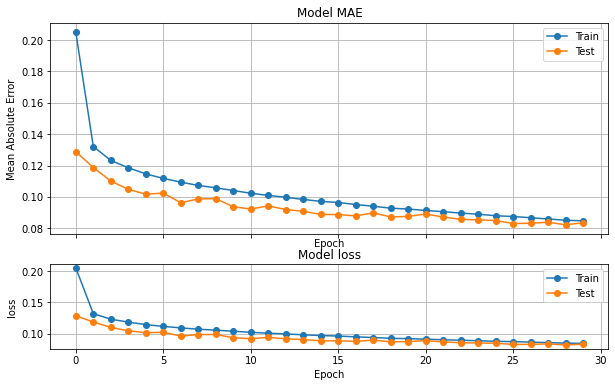

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2,
                               ncols=1,
                               figsize=(10, 6),
                               sharex=True,
                               gridspec_kw = {'height_ratios':[5, 2]})

ax1.plot(range(EPOCHS), hist.history['mae'], '-o', color='#1f77b4', label='Train')
ax1.plot(range(EPOCHS), hist.history['val_mae'], '-o', color='#ff7f0e', label='Test')
ax1.grid(True)
ax1.set_title("Model MAE")
ax1.set(xlabel="Epoch", ylabel="Mean Absolute Error")
ax1.legend()

ax2.plot(range(EPOCHS), hist.history['loss'], '-o', color='#1f77b4', label='Train')
ax2.plot(range(EPOCHS), hist.history['val_loss'], '-o', color='#ff7f0e', label='Test')
ax2.grid(True)
ax2.set_title("Model loss")
ax2.set(xlabel="Epoch", ylabel="loss")

ax2.legend()
plt.show()

In [ ]:
# Model validation

def predict(prediction_model, data_to_predict):
    """ Gives all predictions for numpy data given, using prediction_model """
    prediction = prediction_model.predict(data_to_predict, batch_size=64, verbose=0, callbacks=hist)
    return prediction

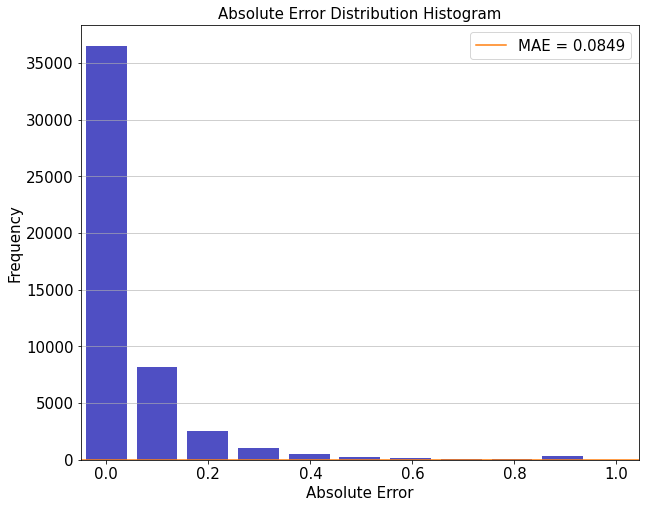

In [ ]:
# Ploting validation results
def plot_stats(prediction, solution):
    error = []
    for p in range(len(prediction)):
        error.append(abs(solution[p] - prediction[p][0]))
    average = np.mean(error) # computing the mean of absolute errors (mae)
    hist,bin_edges = np.histogram(error)

    plt.figure(figsize=[10,8])
    plt.bar(bin_edges[:-1], hist, width = 0.08, color='#0504aa', alpha=0.7)
    plt.plot([-0.05, max(bin_edges)+0.05], [average, average], color='#ff7f0e', label="MAE = {:.4f}".format(average))
    plt.xlim(min(bin_edges)-0.05, max(bin_edges)+0.05)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Absolute Error',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.legend(fontsize=15)
    plt.title('Absolute Error Distribution Histogram',fontsize=15)
    plt.show()

prediction = predict(model, go_validation)
plot_stats(prediction, y_validation)

# Sauvegarder le modèle

Ci-dessous on a la possibilité de sauvegarder notre modèle au format json, pour le réutiliser plus tard. On s'en sert notamment pour garder les modèles performants ou les modèles avec un grand nombre d'epochs, pour ne pas avoir à les réentrainer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# You'll access to all my Drive, please only play with files in the PATH below :)
PATH = "drive/MyDrive/ENSEIRB/2A/ColabNotebooks/saves/"

Mounted at /content/drive


In [ ]:
# Set a name to your model, it will be saved under ColabNotebooks/saves/
model_name = "30-epochs-853"

def save_model(model_name):
    # Does the file already exists ?
    import os
    if os.path.isfile(PATH + model_name + ".json"):
        ans = input(f"/!\\ '{model_name}' already exists. Do you want to overwrite it ? (y/n)")
        if ans != "y" and ans != "yes": return print(" -> Save aborted")

    # Save model to drive as json
    model_json = model.to_json()
    with open(PATH + model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    # Serialize weights to HDF5
    model.save_weights(PATH + model_name + ".h5")
    print("Saved " + model_name + " to Drive")
    return print("You can access it from the files menu, on the right-hand panel of Colab")

save_model(model_name)

Saved 30-epochs-853 to Drive
You can access it from the files menu, on the right-hand panel of Colab


# Charger un modèle déjà entraîné 

Puisque les sessions de Colab n'enregistrent pas les modèles près une fermeture de session, nous avons sauvegardé nos modèles sur Drive. Pour les réutiser directemnt, il suffit de les importer.

In [ ]:
from keras.models import model_from_json

# Select the model you want to load from drive
model_name = "30-epochs-822"

# Load json and create model
json_file = open(PATH + model_name + ".json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model.load_weights(PATH + model_name + ".h5")

print(f"Loaded model \033[3m{model_name}\033[0m from Drive")

Loaded model 30-epochs-822 from Drive


# Prédictions sur les données réelles

Nous téléchargeons les données jamais observées, et avec le modèle précédemment chargé, nous faisons nos prédictions.

Les prédictions sont enregistrées dans un fichier *predictions.txt*

In [ ]:
hdef get_raw_data_go_evaluate():
  """ Returns the set of samples after downloading it """
  import gzip, os.path
  import json
  import urllib.request 

  print("Downloading file...", end="")
  urllib.request.urlretrieve ("https://www.labri.fr/perso/lsimon/ia-inge2/positions-to-evaluate-9x9.json.gz", "positions-to-evaluate-9x9.json.gz")
  print("\033[92m Done\033[0m")

  with gzip.open("positions-to-evaluate-9x9.json.gz") as fz:
    data = json.loads(fz.read().decode("utf-8"))
  return data

# Downloading data
data_evaluate = get_raw_data_go_evaluate()
print("We have", len(data_evaluate), "examples")

# Converting json data to numpy data
print("Converting data to numpy array...", end="")
np_data_evaluate = json_to_matrix(data_evaluate)
print("\033[92m Done\033[0m")

# Using our 'loaded_model' to make predictions on numpy data
print("Making predicions...", end="") 
prediction = predict(loaded_model, np_data_evaluate)
print("\033[92m Done\033[0m")

# Writing our predictions in a txt file
print("Writing predicions in file...", end="")
with open("my_predictions.txt", "w") as f:
    for p in prediction:
        f.write(str(p[0]) + "\n")
print("\033[92m Done\033[0m")
print("You can access to your prediction file in the files menu, on the right-hand panel of Colab")

We have 1000 examples
Converting data to numpy array... Done
Making predicions... Done
Writing predicions in file... Done
You can access to your prediction file in the files menu, on the right-hand panel of Colab
